### Let's start with downloading the raw data

In [1]:
import sys
import os
# to reach the dataloader_functions module
module_path = os.path.abspath(os.path.join( ".."))
if module_path not in sys.path:
    sys.path.append(module_path)

from dataloader_functions.download_data import download_raw_data
current_dir = os.getcwd()

In [2]:
### TODO update this section per dataset
dataset_config = {
    'dataset_name': 'HS_cards',
    'source': 'kaggle', # ['kaggle', 'local', 'openml', 'hf']
    'remote_path': 'jeradrose/hearthstone-cards',
    'files': ['cards_flat.csv'],
    'rename_files': ['hs_cards.csv'],
    'task': 'clf', # ['reg', 'clf']
    'target': 'player_class',
}

In [3]:
if dataset_config['task'] == 'clf':
    dataset_subfolder = os.path.join('raw', 'classification', dataset_config['dataset_name']) 
elif dataset_config['task'] == 'reg':
    dataset_subfolder = os.path.join('raw', 'regression', dataset_config['dataset_name'])
else:
    raise ValueError(f"Unknown task: {dataset_config['task']}")

# this path needs to be modified based on the location of the notebook
download_path = os.path.join(current_dir, '..', '..', 'datasets_files', dataset_subfolder)

if download_raw_data(
    dataset_config=dataset_config,
    download_path=download_path,
    force_download=False,
    remove_unlisted=True,
) is not None:
    print(f"Downloaded {dataset_config['dataset_name']} dataset to {download_path}")

Info: Dataset already downloaded in /home/guptaa/anshul/FreeText_TaBench/datasets_notebooks/classification/../../datasets_files/raw/classification/HS_cards.
Downloaded HS_cards dataset to /home/guptaa/anshul/FreeText_TaBench/datasets_notebooks/classification/../../datasets_files/raw/classification/HS_cards


### Now we need to preprocess the data

In [4]:
from dataloader_functions.load_and_pp_raw_data import _drop_empty_columns, _drop_single_value_columns
from dataloader_functions.utils.data_2_df import read_any_to_df
import pandas as pd

import os
current_dir = os.getcwd()

In [5]:

dataset_files_df = []

if dataset_config['rename_files'] is None or len(dataset_config['rename_files']) == 0:
    dataset_config['rename_files'] = dataset_config['files']

for file in dataset_config['rename_files']:

    file_location = os.path.join(download_path, file)

    print(f"Loading {file_location}")

    dataset_files_df.append(read_any_to_df(file_location))

# example of the loaded df data:
pd.set_option('display.max_columns', None)
dataset_files_df[0].head(n=3)

Loading /home/guptaa/anshul/FreeText_TaBench/datasets_notebooks/classification/../../datasets_files/raw/classification/HS_cards/hs_cards.csv


,id,player_class,type,name,set,text,cost,attack,health,rarity,collectible,flavor,mechanics,dust,play_requirements,race,how_to_earn,how_to_earn_golden,targeting_arrow_text,faction,durability,entourage
0,KARA_00_07,MAGE,SPELL,Astral Portal,KARA,Summon a random <b>Legendary</b> minion.,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{'REQ_NUM_MINION_SLOTS': 1},NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NEW1_008a,DRUID,SPELL,Ancient Teachings,EXPERT1,Draw a card.,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BRM_010t2,DRUID,MINION,Druid of the Flame,BRM,NaN,3.0,2.0,5.0,COMMON,NaN,NaN,NaN,"[40, 400, 5, 50]",NaN,BEAST,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
## Run some basic data cleaning

dataset_files_gen_cleaned = []
missing_ratio_threshold = 0.63 # TODO the threshold can be changed

for df_file in dataset_files_df:
    df_size = df_file.shape
    # 1. Drop columns with more than 50% missing values
    df_file = _drop_empty_columns(df_file, threshold=missing_ratio_threshold)   
    # 2. Drop columns with only one unique value
    df_file = _drop_single_value_columns(df_file)
    # 3. remove duplicates
    df_file = df_file.drop_duplicates()
    # 4. remove rows with missing target values
    df_file = df_file[df_file[dataset_config['target']].notna()]
    # 5. drop unnamed columns
    df_file = df_file.loc[:, ~df_file.columns.str.contains('^Unnamed')]

    dataset_files_gen_cleaned.append(df_file)

    print(f"Dataframe shape before/afrer cleaning: {df_size} / {df_file.shape}")

Dropped: Index(['mechanics', 'dust', 'play_requirements', 'race', 'how_to_earn',
       'how_to_earn_golden', 'targeting_arrow_text', 'faction', 'durability',
       'entourage'],
      dtype='object')
Dataframe shape before/afrer cleaning: (2819, 22) / (2816, 11)


In [7]:
## TODO: Now run custom data cleaning -> remove non-essential columns

cols_to_drop = ['id']

dataset_files_cleaned = []

# assuming for multiple files we still want to drop the same columns
for df_file in dataset_files_gen_cleaned:
    df_size = df_file.shape
    for col in cols_to_drop:
        if col in df_file.columns:
            df_file.drop(col, axis=1, inplace=True)
        else:
            print(f"Column {col} not found in dataframe")

    dataset_files_cleaned.append(df_file)    
    print(f"Dataframe shape before/afrer by-hand cleaning: {df_size} / {df_file.shape}")

dataset_files_cleaned[0].head(n=3)

Dataframe shape before/afrer by-hand cleaning: (2816, 11) / (2816, 10)


,player_class,type,name,set,text,cost,attack,health,rarity,flavor
0,MAGE,SPELL,Astral Portal,KARA,Summon a random <b>Legendary</b> minion.,1.0,NaN,NaN,NaN,NaN
1,DRUID,SPELL,Ancient Teachings,EXPERT1,Draw a card.,0.0,NaN,NaN,NaN,NaN
2,DRUID,MINION,Druid of the Flame,BRM,NaN,3.0,2.0,5.0,COMMON,NaN


In [8]:
# TODO: some custom data cleaning

import copy 
tmp_df = copy.deepcopy(dataset_files_cleaned)
dataset_files_by_hand_cleaned = []

for df_file in dataset_files_cleaned:
    print(f"Dataframe shape before custom cleaning: {df_file.shape}")
    # TODO: add custom data cleaning here
    # 1. drop the cards belonging to class 'deathknight' and 'dream' 
    df_file = df_file[df_file['player_class'] != 'DREAM']
    df_file = df_file[df_file['player_class'] != 'DEATHKNIGHT']

    print(f"Dataframe shape after custom clearning: {df_file.shape}")

    dataset_files_by_hand_cleaned.append(df_file)

# reset the dataframe list to the version before custom cleaning -> next cells work wuth dataset_files_by_hand_cleaned
dataset_files_cleaned = tmp_df

Dataframe shape before custom cleaning: (2816, 10)
Dataframe shape after custom clearning: (2810, 10)


### Now it is time to visualize our changes

In [9]:
pd.set_option('display.max_columns', None)

dataset_files_by_hand_cleaned[0].head(n=3)

,player_class,type,name,set,text,cost,attack,health,rarity,flavor
0,MAGE,SPELL,Astral Portal,KARA,Summon a random <b>Legendary</b> minion.,1.0,NaN,NaN,NaN,NaN
1,DRUID,SPELL,Ancient Teachings,EXPERT1,Draw a card.,0.0,NaN,NaN,NaN,NaN
2,DRUID,MINION,Druid of the Flame,BRM,NaN,3.0,2.0,5.0,COMMON,NaN


Let's figure out which columns should be viewed as categorical / numerical / textual

we can start with a simple heuristic:
1. numerical is everything which
    - keeps most of its character length after non-numeral strip
    - has about the same number of unique values after the strip
    + for the purpose of keeping "semantic information", hand picked columns can be viewed also as non-numerical, that is not the default benchmark approach though

2. categorical is everthing non numerical, which can be then divided into N (where N << Num instances) unique categories

3. textual is everything else

In [10]:
import pandas as pd
import re

def is_mostly_numeric(series, length_threshold=0.5, unique_threshold=0.8):
    """Check if column is mostly numeric after stripping non-numeric chars."""
    stripped = series.astype(str).str.replace(r"[^\d\.\-]", "", regex=True)
    
    original_len = series.astype(str).str.len().replace(0, 1)  # avoid div by zero
    length_ratio = (stripped.str.len() / original_len).mean()

    unique_ratio = stripped.nunique(dropna=False) / max(series.nunique(dropna=False), 1)

    return length_ratio > length_threshold and unique_ratio > unique_threshold

def classify_columns(df, unique_ratio_threshold=None, explicit_nunique_threshold=None):
    """
    Classify dataframe columns into numerical, categorical, textual.
    - numerical: true numerics or digit-heavy strings.
    - categorical: low-cardinality discrete values.
    - textual: high-cardinality free-text fields.

    Params:
    - unique_ratio_threshold: Ratio (e.g., 0.05 = 5% of dataset size)
    - explicit_nunique_threshold: Absolute number (overrides ratio if set)
    """
    n_rows = len(df)

    # Determine threshold
    if explicit_nunique_threshold is not None:
        nunique_threshold = explicit_nunique_threshold
    elif unique_ratio_threshold is not None:
        nunique_threshold = int(unique_ratio_threshold * n_rows)
    else:
        nunique_threshold = int(0.05 * n_rows)  # default 5%

    nunique_threshold = max(10, nunique_threshold)  # safeguard for small datasets
    print(f"Threshold for categorical vs textual: {nunique_threshold}")

    numerical_cols = []
    categorical_cols = []
    textual_cols = []

    for col in df.columns:
        series = df[col]

        if pd.api.types.is_numeric_dtype(series):
            numerical_cols.append(col)
        
        elif pd.api.types.is_string_dtype(series) or pd.api.types.is_object_dtype(series):
            if is_mostly_numeric(series):
                numerical_cols.append(col)
            else:
                nunique = series.nunique(dropna=False)
                if nunique <= nunique_threshold:
                    categorical_cols.append(col)
                else:
                    textual_cols.append(col)
        else:
            print(f"⚠️ Unhandled column type: '{col}' (dtype={series.dtype})")

    print(f"Numerical columns ({len(numerical_cols)}): {numerical_cols}")
    print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols}")
    print(f"Textual columns ({len(textual_cols)}): {textual_cols}")

    return numerical_cols, categorical_cols, textual_cols



# Example usage:
for df_file in dataset_files_by_hand_cleaned:
    # Ratio-based (5% of rows)
    # numerical_cols, categorical_cols, textual_cols = classify_columns(df_file, unique_ratio_threshold=0.05)
    print("")
    # OR explicit value (e.g., anything <= 50 is categorical)
    numerical_cols, categorical_cols, textual_cols = classify_columns(df_file, explicit_nunique_threshold=50)



Threshold for categorical vs textual: 50
Numerical columns (3): ['cost', 'attack', 'health']
Categorical columns (4): ['player_class', 'type', 'set', 'rarity']
Textual columns (3): ['name', 'text', 'flavor']


Now let's just try to visualize the kept features, their example values, and their cat/num/text allocation

In [11]:
summary = []
for col in df_file.columns:
    if col in categorical_cols:
        col_type = "categorical"
        num_categories = df_file[col].nunique(dropna=True)
        num_categories_display = int(num_categories)
    elif col in textual_cols:
        col_type = "textual"
        num_categories = df_file[col].nunique(dropna=True)
        num_categories_display = int(num_categories)
    elif col in numerical_cols:
        col_type = "numerical"
        num_categories = df_file[col].nunique(dropna=True)
        num_categories_display = '~ ' + str(num_categories) + ' ~'
    else:
        col_type = "unknown"
        num_categories_display = '--'

    example = df_file[col].dropna().iloc[0] if df_file[col].dropna().size > 0 else None
    summary.append({
        'Column Name': col,
        'Example Value': str(example),
        'Type': col_type,
        '# Categories': num_categories_display
    })

summary_df = pd.DataFrame(summary)

# TODO: by hand changes of the type and category count -> e.g. for 'Location':
#    # Post-processing: override the type and category count for 'Location'
#    # summary_df.loc[summary_df['Column Name'] == 'Location', 'Type'] = 'textual'
#    # num_categories = df_file['Location'].nunique(dropna=True)
#    # summary_df.loc[summary_df['Column Name'] == 'Location', '# Categories'] = int(num_categories)

display(summary_df)  # Or print(summary_df)


,Column Name,Example Value,Type,# Categories
0,player_class,MAGE,categorical,10
1,type,SPELL,categorical,6
2,name,Astral Portal,textual,2195
3,set,KARA,categorical,17
4,text,Summon a random <b>Legendary</b> minion.,textual,1875
5,cost,1.0,numerical,~ 15 ~
6,attack,2.0,numerical,~ 31 ~
7,health,5.0,numerical,~ 42 ~
8,rarity,COMMON,categorical,5
9,flavor,It's like putting racing stripes and a giant s...,textual,1056


### Saving the processed data and loading it back up

In [12]:
import os
import pandas as pd

# Handle rename_files fallback
if dataset_config['rename_files'] is None or len(dataset_config['rename_files']) == 0:
    dataset_config['rename_files'] = dataset_config['files']

for i, df_file in enumerate(dataset_files_by_hand_cleaned):
    df_with_meta = df_file.copy()

    # Get corresponding file name
    file_name = dataset_config['rename_files'][i]
    file_base = os.path.splitext(file_name)[0]

    # Try assigning multi-index header from summary
    try:
        df_with_meta.columns = pd.MultiIndex.from_frame(
            summary_df[['Column Name', 'Type', '# Categories']]
        )
        local_summary = summary_df.copy()
    except ValueError:
        local_summary = summary_df.copy()
        if dataset_config['target'] in local_summary['Column Name'].values:
            local_summary = local_summary[local_summary['Column Name'] != dataset_config['target']]
            df_with_meta.columns = pd.MultiIndex.from_frame(
                local_summary[['Column Name', 'Type', '# Categories']]
            )
        else:
            raise

    # Construct and save everything together
    output_filename = f"{file_base}_processed.pkl"
    output_path = os.path.join(download_path, output_filename)

    save_bundle = {
        'data': df_with_meta,
        'summary': local_summary,
        'config': dataset_config
    }

    pd.to_pickle(save_bundle, output_path)
    print(f"Saved: {output_path}")


Saved: /home/guptaa/anshul/FreeText_TaBench/datasets_notebooks/classification/../../datasets_files/raw/classification/HS_cards/hs_cards_processed.pkl


In [13]:
import os
import pandas as pd

if dataset_config['task'] == 'clf':
    dataset_subfolder = os.path.join('raw', 'classification', dataset_config['dataset_name']) 
elif dataset_config['task'] == 'reg':
    dataset_subfolder = os.path.join('raw', 'regression', dataset_config['dataset_name'])
else:
    raise ValueError(f"Unknown task: {dataset_config['task']}")

# this path needs to be modified based on the location of the notebook
download_path = os.path.join(current_dir, '..', '..', 'datasets_files', dataset_subfolder)

# Loop through processed files in rename_files
for file_name in dataset_config['rename_files']:
    # Remove .csv or .tsv extension to get the base name
    file_base = os.path.splitext(file_name)[0]
    processed_filename = f"{file_base}_processed.pkl"
    processed_path = os.path.join(download_path, processed_filename)

    # Load the bundled dictionary (data + summary + config)
    bundle = pd.read_pickle(processed_path)

    # Extract components
    loaded_df = bundle['data']
    summary_df = bundle['summary']
    loaded_config = bundle['config']

    print(f"\n=== {file_base.upper()} ===")
    print(f"Loaded config keys: {list(loaded_config.keys())}")

    # Show metadata
    meta_df = pd.DataFrame(loaded_df.columns.tolist(), columns=['Column Name', 'Type', '# Categories'])
    display(meta_df)

    # Flatten for modeling
    loaded_df.columns = loaded_df.columns.get_level_values(0)
    display(loaded_df.head(n=3))



=== HS_CARDS ===
Loaded config keys: ['dataset_name', 'source', 'remote_path', 'files', 'rename_files', 'task', 'target']


,Column Name,Type,# Categories
0,player_class,categorical,10
1,type,categorical,6
2,name,textual,2195
3,set,categorical,17
4,text,textual,1875
5,cost,numerical,~ 15 ~
6,attack,numerical,~ 31 ~
7,health,numerical,~ 42 ~
8,rarity,categorical,5
9,flavor,textual,1056


Column Name,player_class,type,name,set,text,cost,attack,health,rarity,flavor
0,MAGE,SPELL,Astral Portal,KARA,Summon a random <b>Legendary</b> minion.,1.0,NaN,NaN,NaN,NaN
1,DRUID,SPELL,Ancient Teachings,EXPERT1,Draw a card.,0.0,NaN,NaN,NaN,NaN
2,DRUID,MINION,Druid of the Flame,BRM,NaN,3.0,2.0,5.0,COMMON,NaN


['MAGE' 'DRUID' 'NEUTRAL' 'WARRIOR' 'WARLOCK' 'PALADIN' 'SHAMAN' 'HUNTER'
 'ROGUE' 'PRIEST']


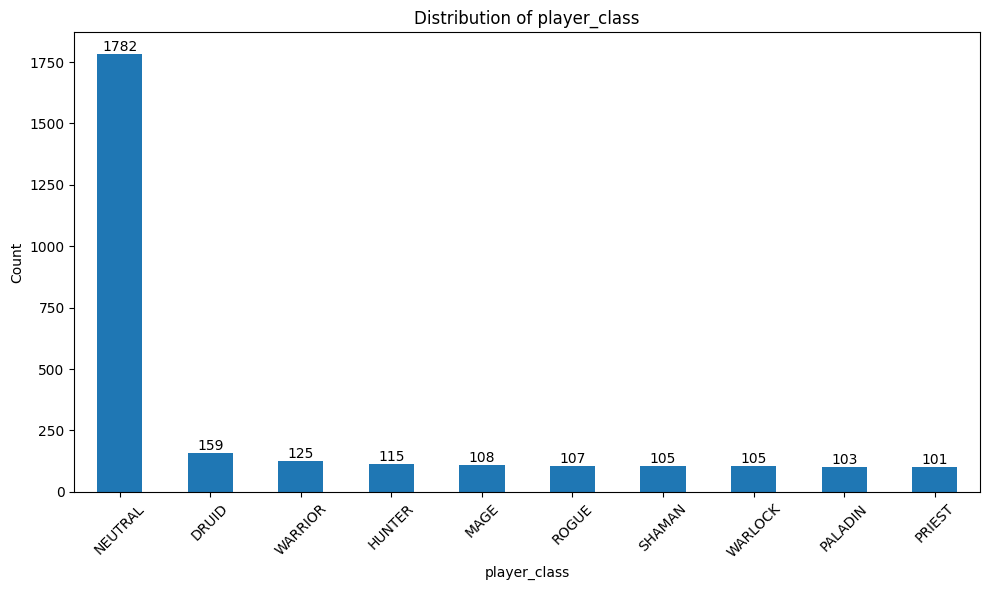

In [14]:
import matplotlib.pyplot as plt

# Print unique values in player_class column
print(loaded_df['player_class'].unique())

# Plot the distribution of player_class with counts
value_counts = loaded_df['player_class'].value_counts()

plt.figure(figsize=(10, 6))
value_counts.plot(kind='bar')

# Add counts as text labels on top of bars
for i, count in enumerate(value_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.title('Distribution of player_class')
plt.xlabel('player_class')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x labels if needed
plt.tight_layout()       # Adjust layout to prevent clipping
plt.show()


In [15]:
from baseline_eval import evaluate_baseline, plot_model_performance_summary
results = evaluate_baseline(
    df=loaded_df,
    model='AGTabular',
    df_name=dataset_config['dataset_name'],
    label_col= dataset_config['target'],
    task_type=dataset_config['task'],
    textual_cols=textual_cols,
    k_folds=5,
    seed=0,
    max_samples=10000,
    output_path=f"../../baseline_results/{dataset_config['task']}/{dataset_config['dataset_name']}.csv"
)

No path specified. Models will be saved in: "AutogluonModels/ag-20250521_181620"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #53~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Wed Jan 15 19:18:46 UTC 2
CPU Count:          64
Memory Avail:       330.45 GB / 503.54 GB (65.6%)
Disk Space Avail:   33795.70 GB / 51214.59 GB (66.0%)
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1



[WRAPPER] Running stratified downsampling mode for task: clf
Info: 
[INFO] Downsampling dataframe: HS_cards (original rows: 2810)
Info: Trying to sample ~1000 rows per class (total=10000)
Info: [INFO] Class MAGE has only 108 instances. Keeping all.
Info: [INFO] Class DRUID has only 159 instances. Keeping all.
Info: [INFO] Class WARRIOR has only 125 instances. Keeping all.
Info: [INFO] Class WARLOCK has only 105 instances. Keeping all.
Info: [INFO] Class PALADIN has only 103 instances. Keeping all.
Info: [INFO] Class SHAMAN has only 105 instances. Keeping all.
Info: [INFO] Class HUNTER has only 115 instances. Keeping all.
Info: [INFO] Class ROGUE has only 107 instances. Keeping all.
Info: [INFO] Class PRIEST has only 101 instances. Keeping all.
Info: Filling up with all remaining 782 samples.
Info: Final downsampled dataset has 2810 rows. Per class counts: [NEUTRAL: 1782, DRUID: 159, WARRIOR: 125, HUNTER: 115, MAGE: 108, ROGUE: 107, SHAMAN: 105, WARLOCK: 105, PALADIN: 103, PRIEST: 101]

Beginning AutoGluon training ... Time limit = 360s
AutoGluon will save models to "/home/guptaa/anshul/FreeText_TaBench/datasets_notebooks/classification/AutogluonModels/ag-20250521_181620"
Train Data Rows:    2248
Train Data Columns: 9
Label Column:       player_class
Problem Type:       multiclass
Preprocessing data ...
Train Data Class Count: 10
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    338413.03 MB
	Train Data (Original)  Memory Usage: 0.91 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting TextSpecialFeatureGen

In [16]:
rs = pd.read_csv(f"../../baseline_results/{dataset_config['task']}/{dataset_config['dataset_name']}.csv")
plot_model_performance_summary(name=dataset_config['dataset_name'],task=dataset_config['task'], df=rs)

Saving plot to ../../baseline_results/plots/clf/score
Saving plot to ../../baseline_results/plots/clf/loss
Saving plot to ../../baseline_results/plots/clf/roc_auc


{'score':                                    mean       std
 model                                            
 AutoGluon_Tabular_without_text  0.65516  0.027376
 AutoGluon_Tabular_with_text     0.70000  0.023390,
 'loss':                                     mean       std
 model                                             
 AutoGluon_Tabular_with_text     1.066827  0.058750
 AutoGluon_Tabular_without_text  1.185922  0.070553,
 'roc_auc':                                     mean       std
 model                                             
 AutoGluon_Tabular_without_text  0.774096  0.017523
 AutoGluon_Tabular_with_text     0.827878  0.006535}